In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [160]:
cut_based = ["dr_bf_c", "dr_ob_c", "dr_aov_c", "dr_bsa_c", "dr_sc_c", "ds_bf_c",
             "ds_acc_c", "nls_c", "dsl_bf_c", "dsl_ascc_c", "dsl_asb_c", "drl_bf_c"]

In [146]:
df = pd.read_csv("group_1.csv")
df["group"] = "G1"
df.head()

,_dettime,cuts_multi_commodity_flow,_best_bound,variables_continuous,_linear_nonzeros,objective_value,variables_integer,cuts_MIR,name,constraints,cuts_benders,cuts_flow_cover,_solve_status,_solve_status_code,cuts_RLT,_quality_metrics,cuts_clique,_problem_type,linear_relaxation,cuts_disjunctive,cuts_fractional,cuts_user,cuts_lift_and_project,variables_binary,_n_nodes_processed,cuts_GUB_cover,cuts_cover,_miprelgap,_ncolumns,_n_iterations,variables_user,cuts_flow_path,cuts_solution_pool,variables,exception,cuts_table,cuts_zero_half,cuts_BQP,cuts_implied_bound,_time,cuts_local_implied_bound,group
0,115607.294655,NaN,NaN,0,467154.0,NaN,0,NaN,dr_sc_c:21n-70m-SpanishTelefonica_30_9_22_0.2,116768,NaN,NaN,"time limit exceeded, no integer solution",108.0,NaN,{},NaN,MILP,4.000000,NaN,NaN,NaN,NaN,400,0.0,NaN,NaN,NaN,400.0,0.0,400,NaN,NaN,400,<class 'AssertionError'>:Solution not found: s...,NaN,NaN,NaN,NaN,60.019451,NaN,G1
1,970.600767,0.0,32.0,0,106644.0,32.0,0,22.0,nls_m:21n-70m-SpanishTelefonica_30_9_22_0.2,26298,0.0,2.0,integer optimal solution,101.0,0.0,{},77.0,MILP,12.416667,0.0,15.0,0.0,0.0,2180,0.0,0.0,181.0,0.0,2180.0,2748.0,2180,0.0,0.0,2180,NaN,0.0,93.0,0.0,0.0,1.343437,0.0,G1
2,18.822218,6.0,13.0,0,1396.0,13.0,80,3.0,dr_bf_f:6n-9m-n6s9_100_50_12_0.5,326,0.0,3.0,integer optimal solution,101.0,0.0,{},0.0,MILP,4.750000,0.0,4.0,0.0,1.0,84,0.0,0.0,6.0,0.0,164.0,99.0,164,0.0,0.0,164,NaN,0.0,2.0,0.0,2.0,0.042323,0.0,G1
3,7660.787668,0.0,22.0,0,87685.0,22.0,0,0.0,ds_bf_c:11n-52m-Pan-European-COST239_10_5_18_0.5,21917,0.0,0.0,integer optimal solution,101.0,0.0,{},0.0,MILP,7.000000,0.0,2.0,601.0,0.0,441,1105.0,0.0,15.0,0.0,441.0,14903.0,441,0.0,0.0,441,NaN,0.0,8.0,0.0,4.0,4.647361,0.0,G1
4,352.600297,19.0,31.0,0,5340.0,31.0,284,57.0,dr_ob_f:21n-70m-SpanishTelefonica_10_3_22_0.2,1218,0.0,78.0,integer optimal solution,101.0,0.0,{},0.0,MILP,11.000000,0.0,13.0,0.0,0.0,292,292.0,0.0,22.0,0.0,576.0,7918.0,576,4.0,0.0,576,NaN,0.0,35.0,0.0,4.0,0.376362,0.0,G1


In [147]:
# Remove underscore from column names
def rename(x: str):
    if x.startswith("_"):
        return x[1:]
    return x


df = df.rename(columns=rename)
df.head()

,dettime,cuts_multi_commodity_flow,best_bound,variables_continuous,linear_nonzeros,objective_value,variables_integer,cuts_MIR,name,constraints,cuts_benders,cuts_flow_cover,solve_status,solve_status_code,cuts_RLT,quality_metrics,cuts_clique,problem_type,linear_relaxation,cuts_disjunctive,cuts_fractional,cuts_user,cuts_lift_and_project,variables_binary,n_nodes_processed,cuts_GUB_cover,cuts_cover,miprelgap,ncolumns,n_iterations,variables_user,cuts_flow_path,cuts_solution_pool,variables,exception,cuts_table,cuts_zero_half,cuts_BQP,cuts_implied_bound,time,cuts_local_implied_bound,group
0,115607.294655,NaN,NaN,0,467154.0,NaN,0,NaN,dr_sc_c:21n-70m-SpanishTelefonica_30_9_22_0.2,116768,NaN,NaN,"time limit exceeded, no integer solution",108.0,NaN,{},NaN,MILP,4.000000,NaN,NaN,NaN,NaN,400,0.0,NaN,NaN,NaN,400.0,0.0,400,NaN,NaN,400,<class 'AssertionError'>:Solution not found: s...,NaN,NaN,NaN,NaN,60.019451,NaN,G1
1,970.600767,0.0,32.0,0,106644.0,32.0,0,22.0,nls_m:21n-70m-SpanishTelefonica_30_9_22_0.2,26298,0.0,2.0,integer optimal solution,101.0,0.0,{},77.0,MILP,12.416667,0.0,15.0,0.0,0.0,2180,0.0,0.0,181.0,0.0,2180.0,2748.0,2180,0.0,0.0,2180,NaN,0.0,93.0,0.0,0.0,1.343437,0.0,G1
2,18.822218,6.0,13.0,0,1396.0,13.0,80,3.0,dr_bf_f:6n-9m-n6s9_100_50_12_0.5,326,0.0,3.0,integer optimal solution,101.0,0.0,{},0.0,MILP,4.750000,0.0,4.0,0.0,1.0,84,0.0,0.0,6.0,0.0,164.0,99.0,164,0.0,0.0,164,NaN,0.0,2.0,0.0,2.0,0.042323,0.0,G1
3,7660.787668,0.0,22.0,0,87685.0,22.0,0,0.0,ds_bf_c:11n-52m-Pan-European-COST239_10_5_18_0.5,21917,0.0,0.0,integer optimal solution,101.0,0.0,{},0.0,MILP,7.000000,0.0,2.0,601.0,0.0,441,1105.0,0.0,15.0,0.0,441.0,14903.0,441,0.0,0.0,441,NaN,0.0,8.0,0.0,4.0,4.647361,0.0,G1
4,352.600297,19.0,31.0,0,5340.0,31.0,284,57.0,dr_ob_f:21n-70m-SpanishTelefonica_10_3_22_0.2,1218,0.0,78.0,integer optimal solution,101.0,0.0,{},0.0,MILP,11.000000,0.0,13.0,0.0,0.0,292,292.0,0.0,22.0,0.0,576.0,7918.0,576,4.0,0.0,576,NaN,0.0,35.0,0.0,4.0,0.376362,0.0,G1


In [148]:
# Split instance data to columns
def name_to_values(name):
    model, instance = name.split(":")
    instance_nodes = instance.split("-")[0].replace("n", "")
    instance_edges = instance.split("-")[1].replace("m", "")
    rest = ''.join(instance.split("-")[2:])
    topology = rest.split("_")[0]
    slots = rest.split("_")[1]
    max_sd = rest.split("_")[2]
    terminals = rest.split("_")[3]
    spread = rest.split("_")[4]

    return {
        "model": model,
        "instance": instance,
        "instance_nodes": int(instance_nodes),
        "instance_edges": int(instance_edges),
        "topology": topology,
        "slots": int(slots),
        "max_sd": int(max_sd),
        "terminals": int(terminals),
        "spread": float(spread)
    }


df["name_values"] = df["name"].apply(func=name_to_values)
df = pd.concat([df, df["name_values"].apply(pd.Series)], axis=1)
df.drop("name_values", axis=1, inplace=True)
df.head()

,dettime,cuts_multi_commodity_flow,best_bound,variables_continuous,linear_nonzeros,objective_value,variables_integer,cuts_MIR,name,constraints,cuts_benders,cuts_flow_cover,solve_status,solve_status_code,cuts_RLT,quality_metrics,cuts_clique,problem_type,linear_relaxation,cuts_disjunctive,cuts_fractional,cuts_user,cuts_lift_and_project,variables_binary,n_nodes_processed,cuts_GUB_cover,cuts_cover,miprelgap,ncolumns,n_iterations,variables_user,cuts_flow_path,cuts_solution_pool,variables,exception,cuts_table,cuts_zero_half,cuts_BQP,cuts_implied_bound,time,cuts_local_implied_bound,group,model,instance,instance_nodes,instance_edges,topology,slots,max_sd,terminals,spread
0,115607.294655,NaN,NaN,0,467154.0,NaN,0,NaN,dr_sc_c:21n-70m-SpanishTelefonica_30_9_22_0.2,116768,NaN,NaN,"time limit exceeded, no integer solution",108.0,NaN,{},NaN,MILP,4.000000,NaN,NaN,NaN,NaN,400,0.0,NaN,NaN,NaN,400.0,0.0,400,NaN,NaN,400,<class 'AssertionError'>:Solution not found: s...,NaN,NaN,NaN,NaN,60.019451,NaN,G1,dr_sc_c,21n-70m-SpanishTelefonica_30_9_22_0.2,21,70,SpanishTelefonica,30,9,22,0.2
1,970.600767,0.0,32.0,0,106644.0,32.0,0,22.0,nls_m:21n-70m-SpanishTelefonica_30_9_22_0.2,26298,0.0,2.0,integer optimal solution,101.0,0.0,{},77.0,MILP,12.416667,0.0,15.0,0.0,0.0,2180,0.0,0.0,181.0,0.0,2180.0,2748.0,2180,0.0,0.0,2180,NaN,0.0,93.0,0.0,0.0,1.343437,0.0,G1,nls_m,21n-70m-SpanishTelefonica_30_9_22_0.2,21,70,SpanishTelefonica,30,9,22,0.2
2,18.822218,6.0,13.0,0,1396.0,13.0,80,3.0,dr_bf_f:6n-9m-n6s9_100_50_12_0.5,326,0.0,3.0,integer optimal solution,101.0,0.0,{},0.0,MILP,4.750000,0.0,4.0,0.0,1.0,84,0.0,0.0,6.0,0.0,164.0,99.0,164,0.0,0.0,164,NaN,0.0,2.0,0.0,2.0,0.042323,0.0,G1,dr_bf_f,6n-9m-n6s9_100_50_12_0.5,6,9,n6s9,100,50,12,0.5
3,7660.787668,0.0,22.0,0,87685.0,22.0,0,0.0,ds_bf_c:11n-52m-Pan-European-COST239_10_5_18_0.5,21917,0.0,0.0,integer optimal solution,101.0,0.0,{},0.0,MILP,7.000000,0.0,2.0,601.0,0.0,441,1105.0,0.0,15.0,0.0,441.0,14903.0,441,0.0,0.0,441,NaN,0.0,8.0,0.0,4.0,4.647361,0.0,G1,ds_bf_c,11n-52m-Pan-European-COST239_10_5_18_0.5,11,52,PanEuropeanCOST239,10,5,18,0.5
4,352.600297,19.0,31.0,0,5340.0,31.0,284,57.0,dr_ob_f:21n-70m-SpanishTelefonica_10_3_22_0.2,1218,0.0,78.0,integer optimal solution,101.0,0.0,{},0.0,MILP,11.000000,0.0,13.0,0.0,0.0,292,292.0,0.0,22.0,0.0,576.0,7918.0,576,4.0,0.0,576,NaN,0.0,35.0,0.0,4.0,0.376362,0.0,G1,dr_ob_f,21n-70m-SpanishTelefonica_10_3_22_0.2,21,70,SpanishTelefonica,10,3,22,0.2


In [149]:
instances = df[["instance_nodes", "instance_edges", "slots", "max_sd", "topology", "spread", "terminals", "group"]].drop_duplicates(
).sort_values(["instance_nodes", "instance_edges", "slots", "max_sd", "topology", "spread", "terminals"])
instances

,instance_nodes,instance_edges,slots,max_sd,topology,spread,terminals,group
80,6,9,10,1,n6s9,0.2,60,G1
16,6,9,10,1,n6s9,0.5,60,G1
232,6,9,10,1,n6s9,1.0,60,G1
101,6,9,10,3,n6s9,0.2,20,G1
47,6,9,10,3,n6s9,0.5,20,G1
...,...,...,...,...,...,...,...,...
27,43,176,10,3,EuroLarge,0.2,26,G1
62,43,176,10,5,EuroLarge,0.2,16,G1
188,43,176,30,3,EuroLarge,0.2,80,G1
6,43,176,30,9,EuroLarge,0.2,26,G1


In [150]:
# Map statuses

def map_status(row):
    status = row["solve_status"]
    exception = row["exception"]
    if status == "integer optimal solution":
        return "OPTIMAL"
    if status == "time limit exceeded":
        return "TIME_LIMIT_SOLUTION"
    if status == "time limit exceeded, no integer solution":
        return "TIME_LIMIT_NO_SOLUTION"
    if status in ["CPLEX Error  1001: Out of memory.", "CPLEX Error  1001: Out of memory.\n"]:
        return "OUT_OF_MEMORY"
    if "MemoryError" in exception or "CPLEX Error  1001: Out of memory." in exception:
        return "OUT_OF_MEMORY"
    else:
        return "UNKNOWN"


df["status"] = df.apply(func=map_status, axis=1)
df["status"].value_counts()

status
OPTIMAL                   1108
TIME_LIMIT_NO_SOLUTION     299
TIME_LIMIT_SOLUTION        162
OUT_OF_MEMORY              141
Name: count, dtype: int64

In [151]:
def solved_objective_value(row):
    objective_value = row["objective_value"]
    optimal = row["status"] == "OPTIMAL"
    if optimal:
        return objective_value


df["solved_objective_value"] = df.apply(func=solved_objective_value, axis=1)

instance_solutions = df.groupby(["instance"])["solved_objective_value"].max()
df = df.join(instance_solutions, on="instance", rsuffix="_instance")
df.drop("solved_objective_value", axis=1, inplace=True)
df.rename(columns={
    "solved_objective_value_instance": "solved_objective_value"}, inplace=True)
df.head()

,dettime,cuts_multi_commodity_flow,best_bound,variables_continuous,linear_nonzeros,objective_value,variables_integer,cuts_MIR,name,constraints,cuts_benders,cuts_flow_cover,solve_status,solve_status_code,cuts_RLT,quality_metrics,cuts_clique,problem_type,linear_relaxation,cuts_disjunctive,cuts_fractional,cuts_user,cuts_lift_and_project,variables_binary,n_nodes_processed,cuts_GUB_cover,cuts_cover,miprelgap,ncolumns,n_iterations,variables_user,cuts_flow_path,cuts_solution_pool,variables,exception,cuts_table,cuts_zero_half,cuts_BQP,cuts_implied_bound,time,cuts_local_implied_bound,group,model,instance,instance_nodes,instance_edges,topology,slots,max_sd,terminals,spread,status,solved_objective_value
0,115607.294655,NaN,NaN,0,467154.0,NaN,0,NaN,dr_sc_c:21n-70m-SpanishTelefonica_30_9_22_0.2,116768,NaN,NaN,"time limit exceeded, no integer solution",108.0,NaN,{},NaN,MILP,4.000000,NaN,NaN,NaN,NaN,400,0.0,NaN,NaN,NaN,400.0,0.0,400,NaN,NaN,400,<class 'AssertionError'>:Solution not found: s...,NaN,NaN,NaN,NaN,60.019451,NaN,G1,dr_sc_c,21n-70m-SpanishTelefonica_30_9_22_0.2,21,70,SpanishTelefonica,30,9,22,0.2,TIME_LIMIT_NO_SOLUTION,32.0
1,970.600767,0.0,32.0,0,106644.0,32.0,0,22.0,nls_m:21n-70m-SpanishTelefonica_30_9_22_0.2,26298,0.0,2.0,integer optimal solution,101.0,0.0,{},77.0,MILP,12.416667,0.0,15.0,0.0,0.0,2180,0.0,0.0,181.0,0.0,2180.0,2748.0,2180,0.0,0.0,2180,NaN,0.0,93.0,0.0,0.0,1.343437,0.0,G1,nls_m,21n-70m-SpanishTelefonica_30_9_22_0.2,21,70,SpanishTelefonica,30,9,22,0.2,OPTIMAL,32.0
2,18.822218,6.0,13.0,0,1396.0,13.0,80,3.0,dr_bf_f:6n-9m-n6s9_100_50_12_0.5,326,0.0,3.0,integer optimal solution,101.0,0.0,{},0.0,MILP,4.750000,0.0,4.0,0.0,1.0,84,0.0,0.0,6.0,0.0,164.0,99.0,164,0.0,0.0,164,NaN,0.0,2.0,0.0,2.0,0.042323,0.0,G1,dr_bf_f,6n-9m-n6s9_100_50_12_0.5,6,9,n6s9,100,50,12,0.5,OPTIMAL,13.0
3,7660.787668,0.0,22.0,0,87685.0,22.0,0,0.0,ds_bf_c:11n-52m-Pan-European-COST239_10_5_18_0.5,21917,0.0,0.0,integer optimal solution,101.0,0.0,{},0.0,MILP,7.000000,0.0,2.0,601.0,0.0,441,1105.0,0.0,15.0,0.0,441.0,14903.0,441,0.0,0.0,441,NaN,0.0,8.0,0.0,4.0,4.647361,0.0,G1,ds_bf_c,11n-52m-Pan-European-COST239_10_5_18_0.5,11,52,PanEuropeanCOST239,10,5,18,0.5,OPTIMAL,22.0
4,352.600297,19.0,31.0,0,5340.0,31.0,284,57.0,dr_ob_f:21n-70m-SpanishTelefonica_10_3_22_0.2,1218,0.0,78.0,integer optimal solution,101.0,0.0,{},0.0,MILP,11.000000,0.0,13.0,0.0,0.0,292,292.0,0.0,22.0,0.0,576.0,7918.0,576,4.0,0.0,576,NaN,0.0,35.0,0.0,4.0,0.376362,0.0,G1,dr_ob_f,21n-70m-SpanishTelefonica_10_3_22_0.2,21,70,SpanishTelefonica,10,3,22,0.2,OPTIMAL,31.0


In [152]:
# Add linear relaxation gap, we set as 0 values close to 0
df["linear_relaxation_gap"] = ((df["solved_objective_value"] - df["linear_relaxation"]) /
                               df["solved_objective_value"]).map(lambda x: 0 if x < 0.001 else x)
df[["solved_objective_value", "linear_relaxation", "linear_relaxation_gap"]]

,solved_objective_value,linear_relaxation,linear_relaxation_gap
0,32.0,4.000000,0.875000
1,32.0,12.416667,0.611979
2,13.0,4.750000,0.634615
3,22.0,7.000000,0.681818
4,31.0,11.000000,0.645161
...,...,...,...
1705,20.0,9.833333,0.508333
1706,20.0,4.000000,0.800000
1707,22.0,18.083333,0.178030
1708,32.0,7.558333,0.763802


In [153]:
# %%
metrics_by_model = df.groupby("model").agg(
    status_optimal=pd.NamedAgg(
        column="status", aggfunc=lambda x: (x == "OPTIMAL").sum()),
    status_time_limit_solution=pd.NamedAgg(
        column="status", aggfunc=lambda x: (x == "TIME_LIMIT_SOLUTION").sum()),
    status_time_limit_no_solution=pd.NamedAgg(
        column="status", aggfunc=lambda x: (x == "TIME_LIMIT_NO_SOLUTION").sum()),
    status_out_of_memory=pd.NamedAgg(
        column="status", aggfunc=lambda x: (x == "OUT_OF_MEMORY").sum()),
    status_unknown=pd.NamedAgg(
        column="status", aggfunc=lambda x: (x == "UNKNOWN").sum())
)


def optimal_metrics(x):
    x = df[(x.name == df["model"]) & (df["status"] == "OPTIMAL")]
    return {
        "avg_time": x["time"].mean(),
        "min_time": x["time"].min(),
        "max_time": x["time"].max(),
        "max_linear_relaxation_gap": x["linear_relaxation_gap"].max(),
        "min_linear_relaxation_gap": x["linear_relaxation_gap"].min(),
        "mean_linear_relaxation_gap": x["linear_relaxation_gap"].mean(),
        "avg_n_nodes_processed": x["n_nodes_processed"].mean(),
        "min_n_nodes_processed": x["n_nodes_processed"].min(),
        "max_n_nodes_processed": x["n_nodes_processed"].max(),
    }


metrics_by_model = metrics_by_model.join(
    metrics_by_model.apply(optimal_metrics, axis=1, result_type="expand"))

metrics_by_model

,status_optimal,status_time_limit_solution,status_time_limit_no_solution,status_out_of_memory,status_unknown,avg_time,min_time,max_time,max_linear_relaxation_gap,min_linear_relaxation_gap,mean_linear_relaxation_gap,avg_n_nodes_processed,min_n_nodes_processed,max_n_nodes_processed
model,,,,,,,,,,,,,,
dr_aov_c,38,12,7,0,0,2.647517,0.020096,42.421410,0.870968,0.142857,0.650809,2143.789474,0.0,47846.0
dr_aov_f,56,1,0,0,0,3.061784,0.012932,45.829692,0.798519,0.000000,0.528832,425.678571,0.0,4490.0
dr_aov_m,57,0,0,0,0,1.244956,0.017270,10.927368,0.798519,0.000000,0.492118,78.771930,0.0,4490.0
dr_bf_c,40,10,7,0,0,5.149742,0.021026,37.595129,0.875000,0.142857,0.658191,8553.525000,0.0,142008.0
dr_bf_f,55,2,0,0,0,2.406212,0.013103,39.055894,0.798519,0.000000,0.526130,483.800000,0.0,6544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dsl_bf_c,0,20,32,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dsl_bf_m,27,1,6,23,0,12.510949,0.168148,53.693161,0.734568,0.000000,0.473077,0.000000,0.0,0.0
nls_c,28,7,20,2,0,10.687636,0.037606,57.182377,0.875000,0.142857,0.697603,2335.321429,0.0,38937.0


# Solved instances

In [154]:
metrics_by_model_sorted = metrics_by_model.sort_values(
    ['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
     'status_out_of_memory'], ascending=False)
with pd.option_context('display.max_rows', None):
    display(metrics_by_model_sorted[['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
                                     'status_out_of_memory']])

,status_optimal,status_time_limit_solution,status_time_limit_no_solution,status_out_of_memory
model,,,,
dr_aov_m,57,0,0,0
dr_bf_m,57,0,0,0
dr_ob_m,57,0,0,0
dr_aov_f,56,1,0,0
dr_bf_f,55,2,0,0
dr_ob_f,55,2,0,0
dr_bsa_m,48,3,0,6
nls_m,47,2,5,3
nls_f,46,2,5,4


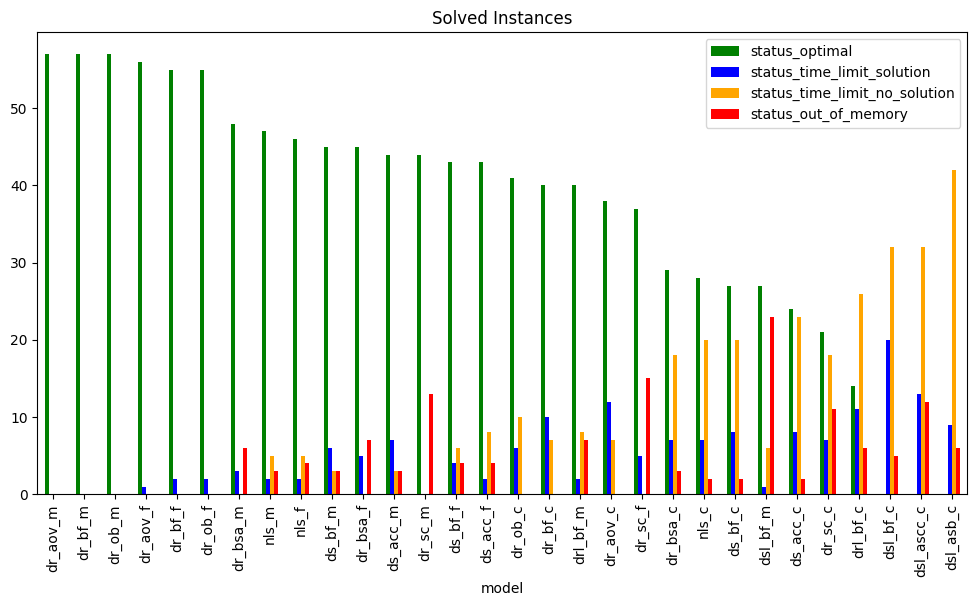

In [155]:
fig, ax = plt.subplots(figsize=(12, 6))
metrics_by_model_sorted[['status_optimal', 'status_time_limit_solution', 'status_time_limit_no_solution',
                         'status_out_of_memory']].plot(title="Solved Instances", kind='bar', ax=ax, color=['green', 'blue', 'orange', 'red'])

plt.show()

# Relative Gap

In [170]:
df_relaxation_gap_sorted = df[~df['model'].isin(cut_based)].groupby(
    'model')['linear_relaxation_gap'].mean().sort_values()
with pd.option_context('display.max_rows', None):
    display(df_relaxation_gap_sorted.reset_index())

,model,linear_relaxation_gap
0,dsl_bf_m,0.471636
1,dr_ob_m,0.491679
2,dr_aov_m,0.492118
3,dr_bf_m,0.492118
4,drl_bf_m,0.499896
5,nls_m,0.502601
6,ds_bf_m,0.502601
7,ds_acc_m,0.502601
8,dr_sc_m,0.524989
9,dr_bsa_m,0.529169


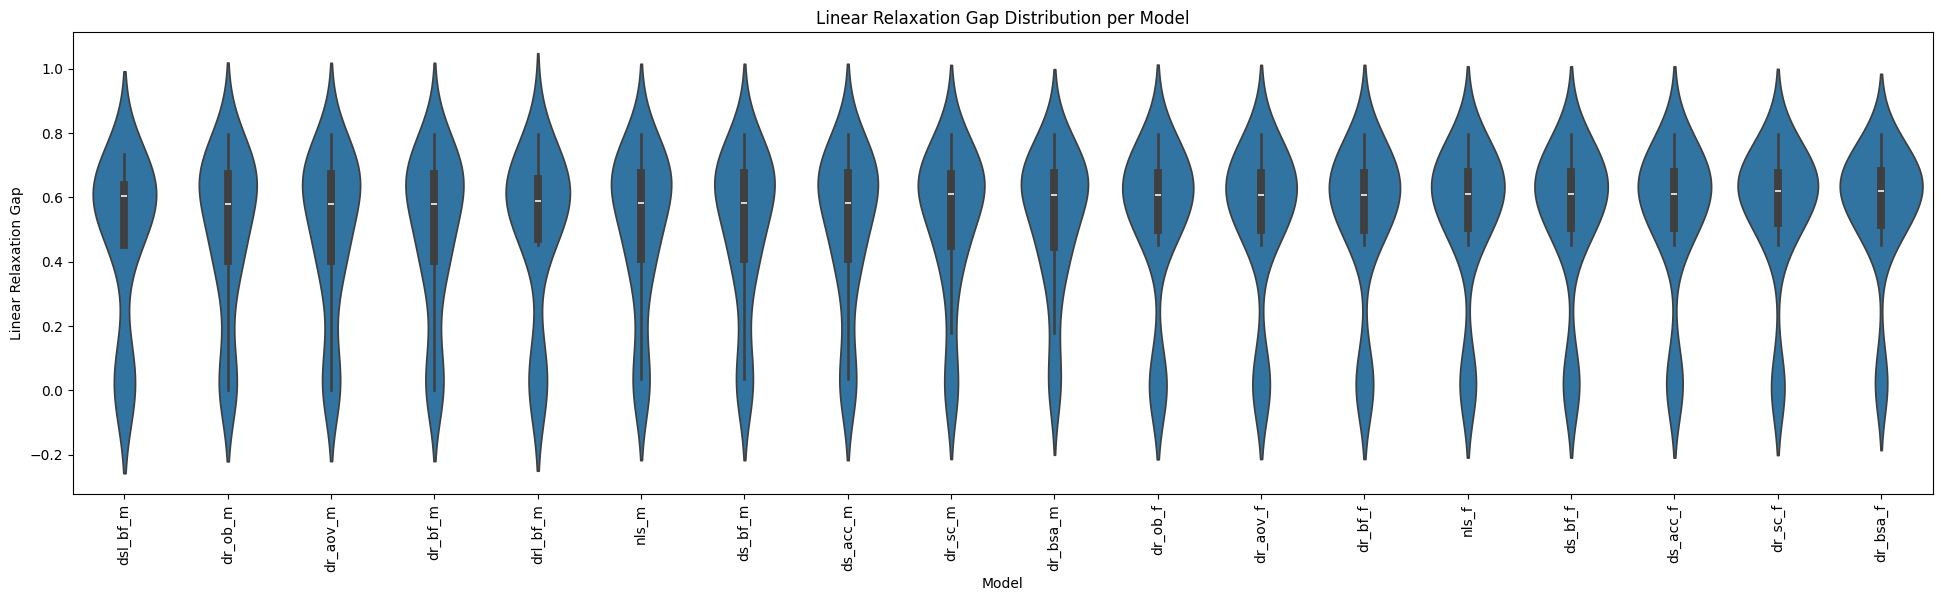

In [171]:
fig, ax = plt.subplots(figsize=(24, 6))
sns.violinplot(data=df, x='model', y='linear_relaxation_gap',
               order=df_relaxation_gap_sorted.index, ax=ax)
plt.xlabel('Model')
plt.ylabel('Linear Relaxation Gap')
plt.xticks(rotation=90)
plt.title('Linear Relaxation Gap Distribution per Model')
plt.show()